<a href="https://colab.research.google.com/github/nah16d/Deep-Learning-in-Malaria-and-Covid-Detection/blob/main/COVID%20XRay/Viral_InceptionV3_XRay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!nvidia-smi

Mon Feb  1 15:28:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


import cv2
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

In [4]:
#define size to which images are to be resized
IMAGE_SIZE = [224, 224] # feel free to change depending on dataset

# training config:
epochs = 100
batch_size = 32

#define paths
viral_path = '/content/drive/MyDrive/COVID/Datasets/XRay/ViralPneumonia'
normal_path = '/content/drive/MyDrive/COVID/Datasets/XRay/Normal'

# Use glob to grab images from path .jpg or jpeg
viral_files = glob(viral_path + '/*')
normal_files = glob(normal_path + '/*')

In [5]:
# Visualize file variable contents
print("Total viral Files: ",len(viral_files))
print("Total Normal Files: ",len(normal_files))

Total viral Files:  412
Total Normal Files:  880


In [6]:
# Fetch Images and Class Labels from Files
viral_labels = []
normal_labels = []

viral_images=[]
normal_images=[]

for i in range(len(viral_files)):
  image = cv2.imread(viral_files[i]) # read file 
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # arrange format as per kera
  image = cv2.resize(image,(224,224)) # resize as per model
  viral_images.append(image) # append image
  viral_labels.append('XRay_viral') # append class label
for i in range(len(normal_files)):
  image = cv2.imread(normal_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  normal_images.append(image)
  normal_labels.append('XRay_normal')

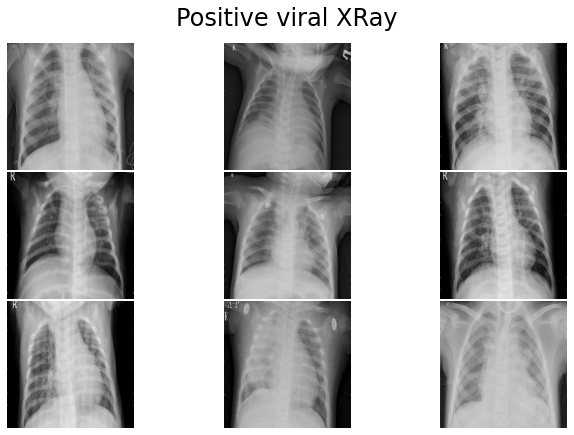

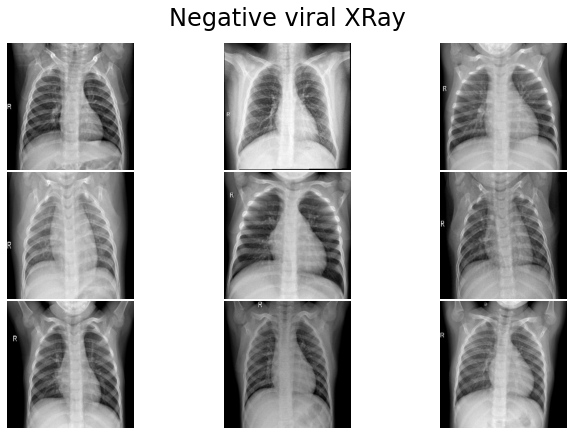

In [7]:
# look at a random image for fun
def plot_images(images, title):
    nrows, ncols = 3, 3
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images(viral_images, 'Positive viral XRay')
plot_images(normal_images, 'Negative viral XRay')

In [8]:
# Convert to array and Normalize to interval of [0,1]
viral_images = np.array(viral_images) / 255
normal_images = np.array(normal_images) / 255

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

# split into training and testing
viral_x_train, viral_x_test, viral_y_train, viral_y_test = train_test_split(
    viral_images, viral_labels, test_size=0.2)
normal_x_train, normal_x_test, normal_y_train, normal_y_test = train_test_split(
    normal_images, normal_labels, test_size=0.2)


X_train = np.concatenate((normal_x_train, viral_x_train), axis=0)
X_test = np.concatenate((normal_x_test, viral_x_test), axis=0)
y_train = np.concatenate((normal_y_train, viral_y_train), axis=0)
y_test = np.concatenate((normal_y_test, viral_y_test), axis=0)

# make labels into categories - either 0 or 1
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

In [10]:
# split into training and testing
viral_x_train, viral_x_test, viral_y_train, viral_y_test = train_test_split(
    viral_images, viral_labels, test_size=0.2)
normal_x_train, normal_x_test, normal_y_train, normal_y_test = train_test_split(
    normal_images, normal_labels, test_size=0.2)


X_train = np.concatenate((normal_x_train, viral_x_train), axis=0)
X_test = np.concatenate((normal_x_test, viral_x_test), axis=0)
y_train = np.concatenate((normal_y_train, viral_y_train), axis=0)
y_test = np.concatenate((normal_y_test, viral_y_test), axis=0)

# make labels into categories - either 0 or 1
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

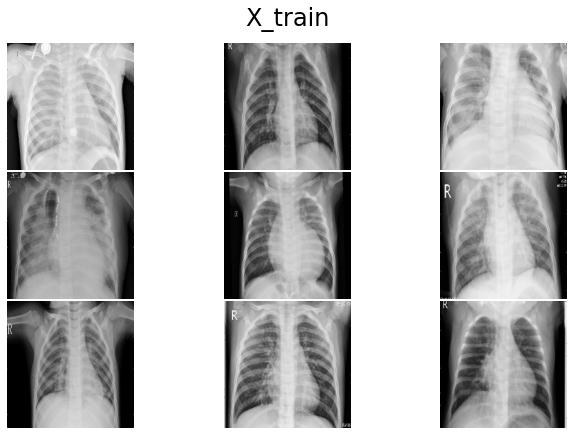

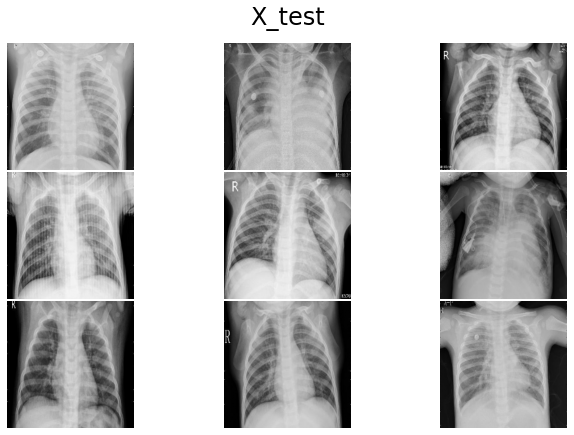

In [11]:
plot_images(viral_x_train, 'X_train')
plot_images(viral_x_test, 'X_test')
# y_train and y_test contain class lables 0 and 1 representing viral and normal for X_train and X_test

In [12]:
inception = InceptionV3(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = inception.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=inception.input, outputs=outputs)

for layer in inception.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

87916544/87910968 [==============================] - 1s 0us/step


In [13]:
# Visualize Model
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [14]:
train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

In [15]:
history = model.fit(train_aug.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / batch_size,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=epochs)

Epoch 1/100
32/32 [==============================] - 23s 397ms/step - loss: 4.3079 - accuracy: 0.7042 - val_loss: 0.6094 - val_accuracy: 0.8726
Epoch 2/100
32/32 [==============================] - 11s 352ms/step - loss: 0.5879 - accuracy: 0.9115 - val_loss: 0.6169 - val_accuracy: 0.8919
Epoch 3/100
32/32 [==============================] - 11s 350ms/step - loss: 0.5464 - accuracy: 0.9175 - val_loss: 0.8448 - val_accuracy: 0.8610
Epoch 4/100
32/32 [==============================] - 11s 350ms/step - loss: 0.6284 - accuracy: 0.8886 - val_loss: 0.9487 - val_accuracy: 0.8533
Epoch 5/100
32/32 [==============================] - 11s 346ms/step - loss: 0.4447 - accuracy: 0.9402 - val_loss: 0.6695 - val_accuracy: 0.8803
Epoch 6/100
32/32 [==============================] - 11s 348ms/step - loss: 0.6028 - accuracy: 0.9204 - val_loss: 0.5813 - val_accuracy: 0.8803
Epoch 7/100
32/32 [==============================] - 11s 352ms/step - loss: 1.0118 - accuracy: 0.8938 - val_loss: 0.3268 - val_accuracy:

In [16]:
# Save Model and Weights
model.save('Viral_InceptionV3_XRay.h5')
model.save_weights('Viral_InceptionV3_XRay.hdf5')

In [17]:
import tensorflow as tf
from tensorflow import keras
tf.keras.models.save_model(model, '/content/drive/MyDrive/COVID/Viral_InceptionV3_XRay.h5')
tf.keras.models.save_model(model, '/content/drive/MyDrive/COVID/Viral_InceptionV3_XRay.hdf5')

In [18]:
# Load saved model
model = load_model('/content/drive/MyDrive/COVID/Viral_InceptionV3_XRay.h5')

In [19]:
y_pred = model.predict(X_test, batch_size=batch_size)

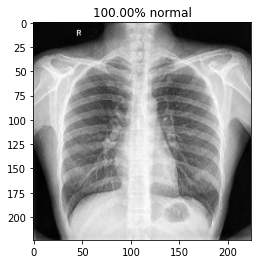

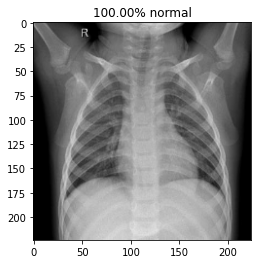

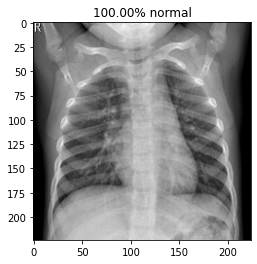

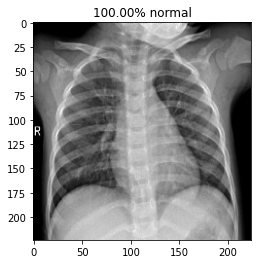

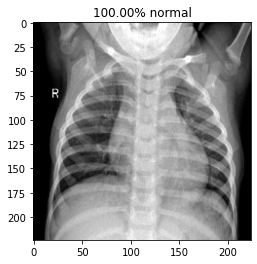

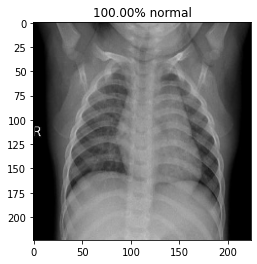

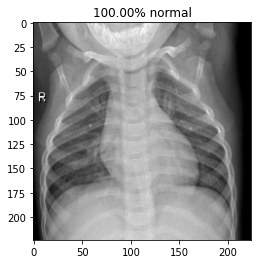

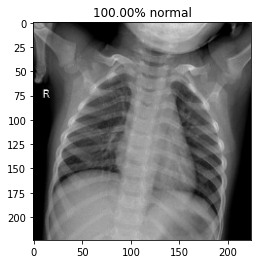

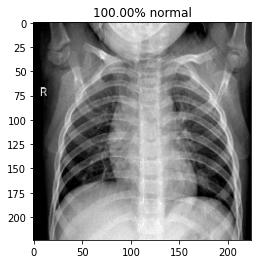

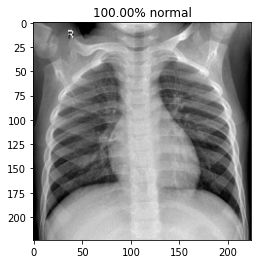

In [20]:
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% viral')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% normal')
  plt.style.reload_library
  plt.imshow(X_test[index])
  plt.show()

In [21]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

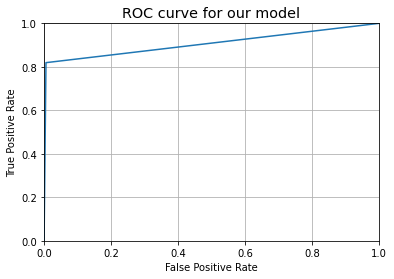

In [22]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

Confusion Matrix without Normalization


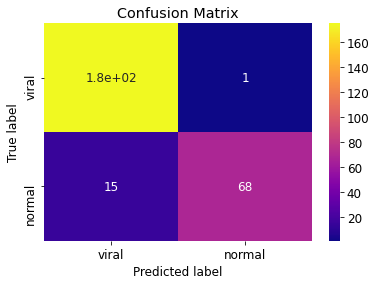

Confusion Matrix with Normalized Values


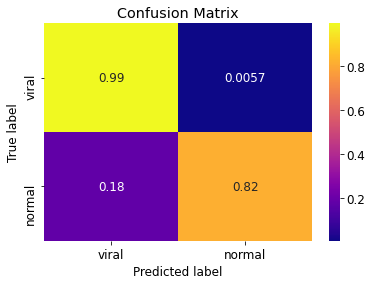

In [23]:
def plot_confusion_matrix(normalize):
  classes = ['viral','normal']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

In [24]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.92      0.99      0.96       176
           1       0.99      0.82      0.89        83

    accuracy                           0.94       259
   macro avg       0.95      0.91      0.93       259
weighted avg       0.94      0.94      0.94       259



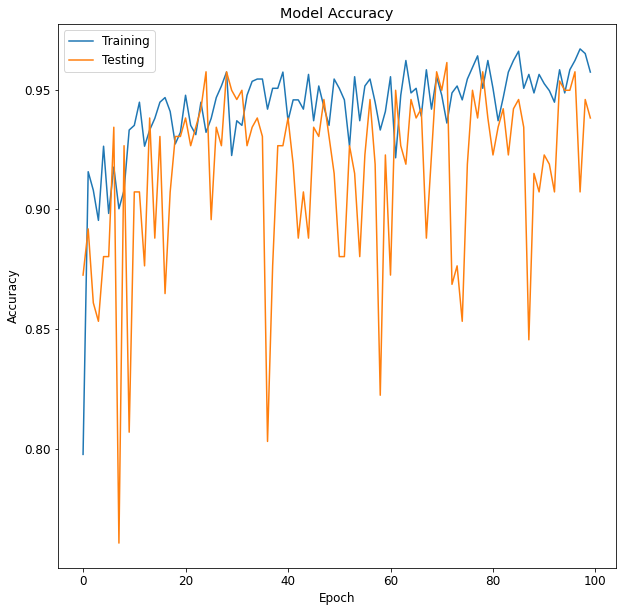

In [25]:
plt.figure(figsize=(10,10))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('Viral_InceptionV3_XRay_accuracy.png')
plt.show()


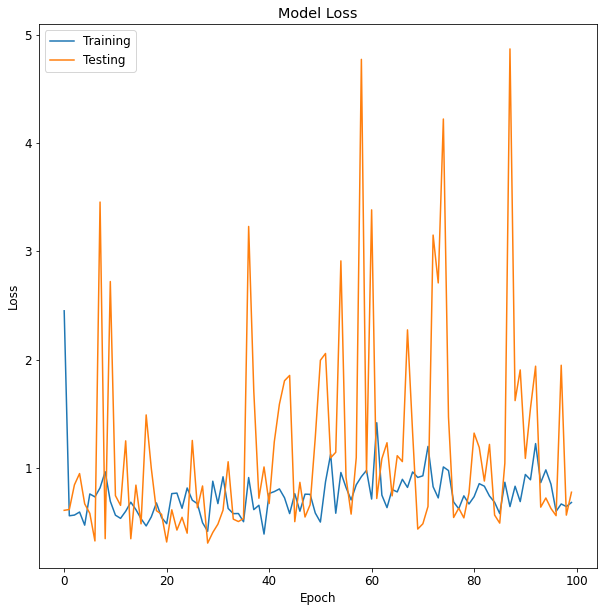

In [26]:
plt.figure(figsize=(10,10))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('Viral_InceptionV3_XRay_loss.png')
plt.show()

In [27]:
#ACCURACY
from sklearn.metrics import accuracy_score
print('Accuracy score:' , accuracy_score(y_test_bin, y_pred_bin))

Accuracy score: 0.9382239382239382
